In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import caffe                            
import math
import seaborn as sns
caffe.set_mode_cpu()
caffe_root='/home/ldy/workspace/caffe/'  #set your caffe_root

In [4]:
print 'load the structure of your model...'
model_def = caffe_root + 'models/finetune_UCMerced_LandUse/deploy1.prototxt'
print 'load the weights of your model...'
model_weights = caffe_root + 'models/finetune_UCMerced_LandUse/weights_finally.pretrained.caffemodel'
print 'build the net...'
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# load the mean ImageNet image for subtraction
mu = np.load('/home/ldy/workspace/caffe/examples/finetune_UCMerced_LandUse/mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
#print 'mean-subtracted values:', zip('BGR', mu),mu

# create trasformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR



load the structure of the model...
load the weights of the model...
build the net...


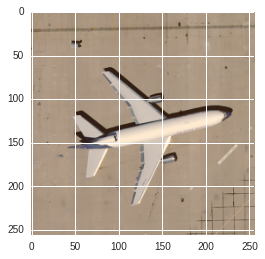

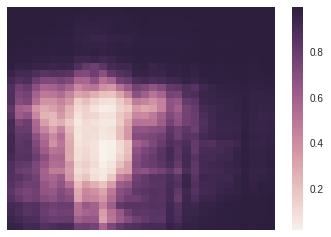

In [9]:
def Occlusion_exp():
    image_url = '/home/ldy/workspace/caffe/data/UCMerced_LandUse/Images/airplane/airplane80.tif'
    image = caffe.io.load_image(image_url)
    plt.imshow(image)
    plt.show()
    
    occluding_size = 100
    occluding_pixel = 0
    occluding_stride = 5

    height, width, _ = image.shape
    
    output_height = int(math.ceil((height-occluding_size)/occluding_stride+1))
    output_width = int(math.ceil((width-occluding_size)/occluding_stride+1))

    heatmap = np.zeros((output_height, output_width))
    
    for h in xrange(output_height):
        for w in xrange(output_width):
            #occluder region
            h_start = h*occluding_stride
            w_start = w*occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            
            input_image = copy.copy(image)
            input_image[h_start:h_end,w_start:w_end,:] =  occluding_pixel
            #plt.imshow(input_image)
            #plt.show()
            transformer_image = transformer.preprocess('data', input_image)
            net.blobs['data'].data[0, ...] = transformer_image
            probs = net.forward(start='conv1')['probs'][0]
            heatmap[h,w] = probs[3] #the probability of the correct class
            
    ax = sns.heatmap(heatmap,xticklabels=False, yticklabels=False)
    plt.show()

Occlusion_exp()